#EECS 504 PS3: Motion Magnification and Texture Synthesis

Please provide the following information 
(e.g. Andrew Owens, ahowens):

[Aohan] [Mei], [rogermei]

[Collaborated with Zheyu Wen]


# Starting

Run the following code to import the modules you'll need. After your finish the assignment, remember to run all cells and save the notebook to your local machine as a .ipynb file for Canvas submission.

In [0]:
%matplotlib inline
import numpy as np
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from numpy import angle, real
from numpy import exp, abs, pi, sqrt
import matplotlib.pyplot as plt
import cv2
import math

import random
import sys
from scipy import ndimage

# cv2.imshow does not work in Colab, we use cv2_imshow instead
from google.colab.patches import cv2_imshow

In [0]:
%%capture
# download some images
# should take a second to run

# for motion magnification problem
! wget -O bill.avi "https://drive.google.com/uc?export=download&id=1QR2dCShn-fYYEvcAQ8J4mnIo_ISqrjc7"

# for texture synthesis problem
! wget -O texture.jpg "https://drive.google.com/uc?export=download&id=11IlTZNLwfYsXQt2L1GbKdNqcj6JNkQik"
! wget -O rings.jpg "https://drive.google.com/uc?export=download&id=1fYtmQe_a40BWg1OU178SFbcU4KRZuphn"
! wget -O jigsaw.jpg "https://drive.google.com/uc?export=download&id=1SlYUw6vT9_PNP8XNhQfAu36AtPJ-PMpk"

## **Problem 3.1 (a)**

In [0]:
def imshow(im, cmap='gray'):
    # clip image from 0-1
    im = np.clip(im, 0, 1)
    plt.imshow(im, cmap=cmap)

In [0]:
# 9x9 images
im_size = 9

# we would like to magnify the change between im1 and im2 by 4x
magnification_factor = 4;

# horizontal movement from (0, 0) to (0, 1)
im1 = np.zeros([im_size, im_size])
im2 = np.zeros([im_size, im_size])
im1[0,0] = 1
im2[0,1] = 1

ff1 = fftshift(fft2(im1))
ff2 = fftshift(fft2(im2))

### This is a quick tutorial for those who are not familiar with complex numbers in python.

In [0]:
# create a complex number
x = 1 + 1j
print("x =", x)
print("x.real", x.real, "x.imag", x.imag)

# magnitude and phase of complex number
mag = abs(x)
phase = angle(x)

print("Magnitude", mag)
print("Phase", phase)

# Euler's formula
y = mag * exp(phase * 1j)
print("y =", y)

x = (1+1j)
x.real 1.0 x.imag 1.0
Magnitude 1.4142135623730951
Phase 0.7853981633974483
y = (1.0000000000000002+1j)


In [0]:
def magnify_change(im1, im2, magnification_factor):
    
    # find phase shift in frequency domain
    im1_dft = fft2(im1)
    im2_dft = fft2(im2)
    phase_shift = angle(im2_dft)-angle(im1_dft)
    
    # magnify the phase change in frequency domain 
    magnified_dft = abs(im1_dft) * exp((angle(im1_dft) + magnification_factor * phase_shift) * 1j)
    
    # what does the magnified phase change cause in image space?
    magnified = ifft2(magnified_dft).real
    
    return magnified

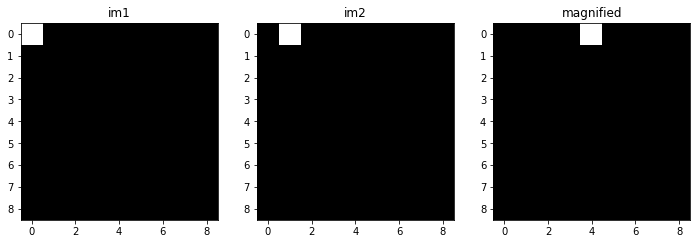

In [0]:
# magnify position change
magnified = magnify_change(im1, im2, magnification_factor);

plt.figure(figsize=(12,36))
plt.subplot(131)
imshow(im1); plt.title('im1');

plt.subplot(132)
imshow(im2); plt.title('im2');

plt.subplot(133)
imshow(magnified); plt.title('magnified');

## **Problem 3.1 (b)**


Explanation: it might due to that the two pixels are correlated during the fourier transform.


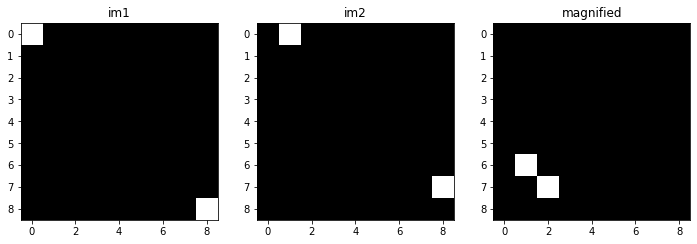

In [0]:
# 9x9 images
im_size = 9

# we would like to magnify the change between im1 and im2 by 4x
magnification_factor = 4

# horizontal movement from (0, 0) to (0, 1)
# additional vertical movement from (8, 8) to (7, 8)
im1 = np.zeros([im_size, im_size])
im2 = np.zeros([im_size, im_size])
im1[0,0] = 1
im2[0,1] = 1
im1[8,8] = 1
im2[7,8] = 1

# magnify position change
magnified = magnify_change(im1, im2, magnification_factor)


plt.figure(figsize=(12,36))
plt.subplot(131)
imshow(im1); plt.title('im1');

plt.subplot(132)
imshow(im2); plt.title('im2');

plt.subplot(133)
imshow(magnified); plt.title('magnified');

# Explanation
print('Explanation: it might due to that the two pixels are correlated during the fourier transform.')

## **Problem 3.1 (c)**


Text(0.5, 1.0, 'magnified')

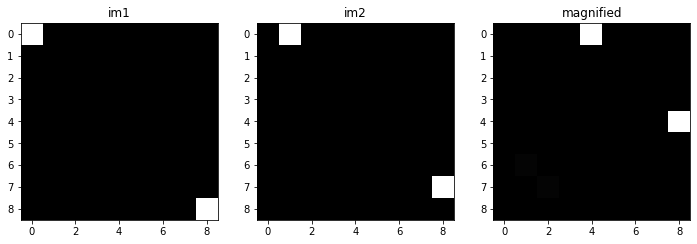

In [0]:
# 9x9 images
im_size = 9

# we would like to magnify the change between im1 and im2 by 4x
magnification_factor = 4

# width of our Gaussian window
sigma = 2

# horizontal movement from (0, 0) to (0, 1)
# additional vertical movement from (8, 8) to (7, 8)
im1 = np.zeros([im_size, im_size])
im2 = np.zeros([im_size, im_size])
im1[0,0] = 1
im2[0,1] = 1
im1[8,8] = 1
im2[7,8] = 1

# we will magnify windows of the image and aggregate the results
magnified = np.zeros([im_size, im_size])

# meshgrid for computing Gaussian window
X, Y = np.meshgrid(np.arange(im_size), np.arange(im_size))

for y in range(0, im_size, 2*sigma):
    for x in range(0, im_size, 2*sigma):
        gaussian_mask = np.exp(-((X-x)**2+(Y-y)**2)/(2*sigma**2))
        window_magnified = magnify_change(gaussian_mask * im1, gaussian_mask * im2, magnification_factor)
        
        magnified = magnified + window_magnified
        
plt.figure(figsize=(12,36))
plt.subplot(131)
imshow(im1); plt.title('im1');

plt.subplot(132)
imshow(im2); plt.title('im2');

plt.subplot(133)
imshow(magnified); plt.title('magnified')

## **Problem 3.1 (d) - Motion Magnification**


In [0]:
import numpy as np
import cv2

cap = cv2.VideoCapture('bill.avi')

# list of video frames
frames = []

while(cap.isOpened()):
    # read frame from the video
    ret, frame = cap.read()
    
    if ret is False:
        break

    frame = cv2.resize(frame, (200, 200), interpolation=cv2.INTER_CUBIC)
    frames.append(frame)

cap.release()

# scale frame to 0-1
frames = np.array(frames) / 255.
print("frames size:", frames.shape, "# (nb_frames, height, width, channel)")

# get height, width
num_frames = frames.shape[0]
height = frames.shape[1]
width = frames.shape[2]

frames size: (60, 200, 200, 3) # (nb_frames, height, width, channel)


In [0]:
# 10x magnification of motion
magnification_factor = 10

# width of Gaussian window
sigma = 26

# alpha for moving average
alpha = 0.5

# we will magnify windows of the video and aggregate the results
magnified = np.zeros_like(frames)

# meshgrid for computing Gaussian window
X, Y = np.meshgrid(np.arange(width), np.arange(height))

# iterate over windows of the frames
x_range = list(range(0, width, 2*sigma))
y_range = list(range(0, height, 2*sigma))
num_windows = len(x_range) * len(y_range)
window_index = 1

for y in y_range:
    for x in x_range:
        for channel_index in range(3): # RGB channels
            for frame_index in range(num_frames):
                
                # create windowed frames
                gaussian_mask = 1/np.sqrt(2*np.pi*sigma**2)*np.exp(-((X-x)**2+(Y-y)**2)/(2*sigma**2))
                windowed_frames = gaussian_mask * frames[frame_index,:,:,channel_index]
            
                # initialize moving average of phase for current window/channel
                if frame_index == 0:
                    window_average_phase = angle(fft2(windowed_frames))
                
                window_dft = fft2(windowed_frames)
                
                # compute phase shift and constrain to [-pi, pi] since
                # angle space wraps around
                window_phase_shift = angle(window_dft) - window_average_phase
                window_phase_shift[window_phase_shift > pi] = window_phase_shift[window_phase_shift > pi] - 2 * pi
                window_phase_shift[window_phase_shift < -pi] = window_phase_shift[window_phase_shift < -pi] + 2 * pi
                
                # magnify phase shift
                window_magnified_phase = angle(window_dft) + magnification_factor * window_phase_shift #TODO6
                 
                # go back to image space
                window_magnified_dft = abs(window_dft) * exp(window_magnified_phase*1j)#TODO7
                window_magnified = abs(ifft2(window_magnified_dft))
                
                # update moving average
                window_phase_unwrapped = window_average_phase + window_phase_shift
                window_average_phase = alpha * window_average_phase + (1 - alpha) * window_phase_unwrapped
                
                # aggregate
                magnified[frame_index,:,:,channel_index] = magnified[frame_index,:,:,channel_index] + window_magnified
        
        # print progress
        print('{}/{}'.format(window_index, num_windows))
        window_index += 1

1/16
2/16
3/16
4/16
5/16
6/16
7/16
8/16
9/16
10/16
11/16
12/16
13/16
14/16
15/16
16/16


In [0]:
outputs = magnified / np.max(magnified)
for channel_index in range(3):
    original_frame = frames[0,:,:,channel_index]
    magnified_frame = outputs[0,:,:,channel_index]
    scale = np.std(original_frame[:]) / np.std(magnified_frame[:])
    original_mean = np.mean(original_frame[:])
    magnified_mean = np.mean(magnified_frame[:])
    outputs[:,:,:,channel_index] = magnified_mean + scale * (outputs[:,:,:,channel_index] - magnified_mean)

outputs = np.clip(outputs, 0, 1)

In [0]:
# create output video
fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
# fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('bill_magnified.avi',fourcc, 30.0, (height, width))

for i in range(frames.shape[0]):
    # scale the frame back to 0-255
    frame = (np.clip(outputs[i], 0, 1) * 255).astype(np.uint8)
    
    # write frame to output video
    out.write(frame)

out.release()

In [0]:
# Only for colab downloading videos
try:
    from google.colab import files
    files.download('bill_magnified.avi')
except:
    print("Only for google colab")

## **Problem 3.2 - Texture Synthesis**

Note that the functions provided below are templates. Feel free to add your own helper functions as needed.

You can reference the pseudocode provided here:  https://people.eecs.berkeley.edu/~efros/research/NPS/alg.html.

### Find matches function

In [0]:
def find_matches(template, sample, sample_pool, gauss_mask):
    ### parameters, as used by Efros and Leung
    epsilon = 0.1
    delta = 0.3
    
    #### TODO:
    # valid_mask is a square mask of width window_size that is 1 where template is filled
    valid_mask = np.zeros(np.shape(gauss_mask))
    valid_mask[template[:,:,0]>0] = 1
    #### TODO:
    # vectorized code that calculates SSD(template, sample)*mask for all patches
    total_weight = np.sum(np.sum(valid_mask*gauss_mask))
    ssd = np.zeros(np.shape(sample[:,:,0]))
    (sample_height,sample_width,_) = np.shape(sample)
    indicater = 0
    for i in range(sample_height):
      for j in range(sample_width):
          sample_select = sample_pool[indicater]
          indicater += 1
          ssd[i,j] = np.sum(np.sum(np.sum((sample_select - template)**2,-1)*valid_mask*gauss_mask))
          if total_weight != 0:
              ssd[i,j] = ssd[i,j]/total_weight
    PixelList = []
    loc = np.where(ssd<=np.min(ssd)*(epsilon+1))
    for i in range(len(loc[0])):
      tuple_loc = tuple([loc[0][i],loc[1][i]])
      error = ssd[loc[0][i],loc[1][i]]
      PixelList.append([tuple_loc,error])
    return PixelList

### Synthesize texture function

In [0]:
from random import choice

def synth_texture(sample, window_size, out_size):
    # normalize pixel intensity
    sample = sample.astype(np.float64)
    sample = sample / 255.0

    seed_size = 10
    [sheight, swidth, channels] = sample.shape
    synth_img = np.zeros((*out_size, channels))

    # initialization: pick a random 3x3 patch from sample and place in the middle of the synthesized image
    rh = round(seed_size + np.random.uniform(0,1) * (sheight - 2 * seed_size))
    rw = round(seed_size + np.random.uniform(0,1) * (swidth - 2 * seed_size))
    center = [round(.5 * x) for x in out_size] # center
    synth_img[center[0]: center[0] + seed_size, center[1]: center[1] + seed_size ,:] = sample[rh: rh + seed_size , rw: rw + seed_size,:]
   
    # bitmap indicating filled pixels, the seed patch is initially filled
    filled = np.zeros(out_size)
    filled[center[0]: center[0] + seed_size , center[1]: center[1] + seed_size] = 1
    num_filled = int(np.sum(filled))
    n_pixels = out_size[0]*out_size[1]

    # TODO
    # intialize 2D zero-mean gaussian w/ variance = (window_size / 6.4)
    X = np.arange(np.ceil(-window_size/2),np.floor(window_size/2)+1)
    Y = np.arange(np.ceil(-window_size/2),np.floor(window_size/2)+1)
    x_gaussian,y_gaussian = np.meshgrid(X,Y)
    gaussian_mask = np.exp(-(x_gaussian**2+y_gaussian**2)/(2*(window_size/6.4)**2))
    # main loop: repeat until all pixels are filled
    next_p = n_pixels / 10

    ## Precompute the sample windowed matrix so that we don't have to compute them in each iteration
    sample_padding = np.zeros([sheight+window_size-1,swidth+window_size-1,channels])
    index_float = np.floor(window_size/2)
    index_int = index_float.astype("int")
    sample_padding[index_int:sheight+index_int,
                   index_int:swidth+index_int,:] = sample
    sample_windowed_pool = []
    for i in range(sheight):
      for j in range(swidth):
        temp = sample_padding[i:i+window_size,j:j+window_size]
        sample_windowed_pool.append(temp)
    delta = 0.3
    while(num_filled < n_pixels):
        # report progress
        if(num_filled > next_p):
            print(round(100 * num_filled / n_pixels), '% complete')
            next_p += n_pixels / 10

        # TODO:
        # get list of unfilled pixels as (x, y) coordinates
        # hint: use dilation and masking to efficiently find unfilled neighboring pixels
        masking = np.ones([window_size,window_size])
        pixel_loc = np.where(filled==0)
        pixel_list_temp = []
        for i in range(len(pixel_loc[0])):
            tuple_loc = tuple([pixel_loc[0][i],pixel_loc[1][i]])
            x = pixel_loc[0][i]
            y = pixel_loc[1][i]
            zeros_mask = np.zeros(out_size)
            zeros_mask[x,y] = 1
            unfilled_neighbor_mask = ndimage.binary_dilation(zeros_mask,structure=masking).astype("int")

            template = np.zeros([window_size,window_size,3])
            loc = np.where(unfilled_neighbor_mask==1)
            length = len(loc[0])
            temp = np.reshape(synth_img[np.min(loc[0]):np.max(loc[0])+1,np.min(loc[1]):np.max(loc[1])+1],
                              (loc[0][length-1]-loc[0][0]+1,loc[1][length-1]-loc[1][0]+1,3))
            num_zeros = window_size*window_size - np.sum(np.sum(temp.nonzero()))
            pixel_list_temp.append([num_zeros,tuple_loc])

        # TODO:
        # (optional, but recommended) randomly permute and sort list of pixels decreasing number of filled neighbor pixels
        pixel_list = sorted(pixel_list_temp)
        # TODO:
        # iterate over the list of pixels
        for _,(x, y) in pixel_list:
          # TODO:
          # place window with center as (x, y) and use as template
          zeros_mask = np.zeros(out_size)
          zeros_mask[x,y] = 1
          unfilled_neighbor_mask = ndimage.binary_dilation(zeros_mask,structure=masking).astype("int")

          template = np.zeros([window_size,window_size,3])
          loc = np.where(unfilled_neighbor_mask==1)
          length = len(loc[0])
          temp = np.reshape(synth_img[np.min(loc[0]):np.max(loc[0])+1,np.min(loc[1]):np.max(loc[1])+1],
                            (loc[0][length-1]-loc[0][0]+1,loc[1][length-1]-loc[1][0]+1,3))
          (height_temp,width_temp,_) = np.shape(temp)
          template[0:height_temp,0:width_temp,:] = temp
          # TODO:
          # find the best matching windows from sample image
          # randomly sample one from best matches
          PixelList = find_matches(template,sample,sample_windowed_pool,gaussian_mask)
          length_pix = len(PixelList)
          choice = np.random.randint(low=0,high=length_pix,size=1)
          if PixelList[choice[0]][1] <= delta:
            (xloc,yloc) = PixelList[choice[0]][0]
            synth_img[x,y,:] = sample[xloc,yloc,:]
            filled[x,y] = 1
            num_filled += 1
          else:
            delta = delta*1.1
    return synth_img*255.0


### Main function

Run the texture synthesis algorithm to generate texture of new shape. 

Source Image


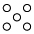

Target Image


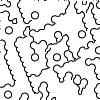

Target Image


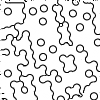

100 % complete
Target Image


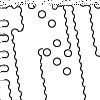

Source Image


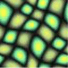

Target Image


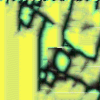

In [0]:
# Texture synthesis on rings
source = cv2.imread('rings.jpg')
window_sizes = [5, 7, 13] 
out_size = [100, 100]

print('Source Image')
cv2_imshow(source)

for w in window_sizes:
  target = synth_texture(source, w, out_size)
  print('Target Image')
  cv2_imshow(target)

w = 5

# Texture synthesis on colored image
source = cv2.imread('texture.jpg')
print('Source Image')
cv2_imshow(source)
target = synth_texture(source, w, out_size)
print('Target Image')
cv2_imshow(target)


# Don't need to submit this one
# source = cv2.imread('jigsaw.jpg')
# print('Source Image')
# cv2_imshow(source)
# target = synth_texture(source, w, out_size)
# print('Target Image')
# cv2_imshow(target)